In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Notes on "A modified next reaction method ..." for time-dependent rates

The goal of these notes is to explain Anderson's (2007) derivation of a stochastic simulation algorithm for a chemical system with reaction rates that depend explicitly on time. His method generalizes the next reaction method, which itself is an alternative to the Gillespie algorithm for simulating chemical systems with time-autonomous reaction rates. First, I will describe the Gillespie and next reaction methods for time-autonomous reaction rates, and second I will describe Anderson's generalization of the next reaction method for nonautonomous rates.

## Time-autonomous chemical systems

The traditional Gillespie algorithm simulates chemical systems with autonomous rates $a_k(X(t))$ which only depend on the current state of the system $X(t)$. One of the fundamental assumptions is that for each reaction $k$:
$$a_k(X(t))\Delta t + \mathcal{o}(\Delta t) = \text{the probability that reaction $k$ takes place in a small time interval $[t, t + \Delta t)$.}$$

Therefore the next firing time of each reaction is exponentially distributed with rate $a_k(X(t))$. The Gillespie algorithm proceeds by generating two random numbers for each time step. One random number is used to find the time that it takes for *something* to happen, and the second random number chooses *which* reaction happened based on the rates of each reaction. 

### Next reaction method

In the Gillespie algorithm, two random numbers must be generated at each time step, and the number of random numbers that must be generated is independent of the number of possible reactions. For chemical systems where the number of time steps is large relative to the number of possible reactions, the next reaction method improves on the Gillespie algorithm in that fewer random numbers are required to advance the simulation. However the feature that is most relevant for these notes is that the next reaction method is more easily generalized to the case where reaction rates are explicitly dependent on time. 

For the next reaction method, we represent the reaction times of each individual reaction as the firing times of Poisson processes. Let $R_k(t)$ be the number of times the $k$th reaction has occurred before time $t$. $R_k(t)$ can be represented as a Poisson process with a nondimensional firing rate related to the reaction rate. Specifically, if we define $k$ independent Poisson processes with unit firing rate: $Y_k(\tau)$, then
$$R_k(t) = Y_k\left(\int_0^t a_k(X(s)) ds \right).$$

Anderson defines the *internal time* of reaction $k$ as $T_k(t)$:
$$T_k(t) \equiv \int_0^t a_k(X(s)) ds.$$
The internal time is a nondimensional quantity that scales time in the $k$th Poisson process based on the reaction rate $a_k(X(t))$. 

The idea of the next reaction method is to calculate the firing times of each Poisson process independently, and then to find the minimum firing time. The system is updated based on which reaction fired, and the internal times of each reaction are updated appropriately. All of the firing times of the other reactions are saved, and a new firing time is generated only for the reaction which fired. 

More explicitly, define $P_k$ to be the first firing time of $Y_k$ (in the time scale of $Y_k$) after $T_k(t)$:
$$P_k(t) = \min\{s > T_k(t) \mid Y_k(s) > Y_k(T_k(t)) \}.$$
Then from the definition of $T_k(t)$ the absolute time required for reaction $k$ to fire $\Delta t_k$ is given by
$$\int_t^{t + \Delta t_k} a_k(X(s)) ds = P_k - T_k.$$

Assuming $X(s)$ is constant in $[t, t + \Delta t_k)$, then so is $a_k$ (as long as $a_k$ doesn't explicitly depend on time) and $\Delta t_k = (P_k - T_k)/a_k$. This gives us the following algorithm for the next reaction method for autonomous reaction rates:
1. Initialize chemical species, set $t=0$, and $T_k = 0$ for each $k$
2. Calculate $a_k$ for each reaction.
3. Generate $M$ independent, uniform random numbers $r_k$.
4. For each $k$, set $P_k = \log(1/r_k)$ (find the internal firing times of each reaction)
5. For each $k$, set $\Delta t_k = (P_k - T_k)/a_k$ (convert the internal firing times to absolute firing times)
6. Set $\Delta = \min_k \{\Delta t_k\}$ and $\mu = \operatorname{argmin}_k \{\Delta t_k\}$
7. Set $t = t + \Delta$ and update the number of molecular species associated with reaction $\mu$
8. For each $k$, set $T_k = T_k + a_k \Delta$ (advance the internal times)
9. For reaction $\mu$, choose a new random number $r$ and set $P_\mu = P_\mu + \log(1/r)$
10. Recalculate the reaction rates $a_k$
11. Go to 5.

In the code below, I simulate a simple enzymatic reaction $\mathrm{A} + \mathrm{B} \rightleftharpoons \mathrm{C} \rightarrow \mathrm{B} + \mathrm{P}$ with rates $k^+ = 1$, $k^- = 5$, and $k^\text{cat} = 5$ using the Gillespie and next reaction methods and compare the results with the solution of the ODE reaction rate equation. This chemical system gives the following set of ODEs:
\begin{align}
\frac{da}{dt} &= -k^+ ab + k^- c \\
\frac{db}{dt} &= -k^+ ab + (k^- + k^\text{cat}) c \\
\frac{dc}{dt} &= k^+ ab - (k^- + k^\text{cat}) c
\end{align}
and the following set of propensity functions $a_k(X(t))$:
\begin{align}
a_1 &= k^+ ab \\
a_2 &= k^- c \\
a_3 &= k^\text{cat} c.
\end{align}

In [22]:
T = 2
kp, km, kcat = 1, 5, 5

In [23]:
def gillespie(y0):
    a0, c0, b0 = y0
    
    a, b, c = np.array([a0]), np.array([b0]), np.array([c0])
    t = np.array([0])
    while t[-1] < T:
        r = np.random.rand(2)
        rates = np.array([kp*a[-1]*b[-1], km*c[-1], kcat*c[-1]])
        cum_rates = np.cumsum(rates, dtype='float64')
        
        if cum_rates[-1] == 0:
            break
        
        dt = 1/cum_rates[-1]*np.log(1/r[0])
        j = np.searchsorted(cum_rates, r[1]*cum_rates[-1])
        t = np.append(t, t[-1] + dt)
        if j == 0:
            a = np.append(a, a[-1] - 1)
            b = np.append(b, b[-1] - 1)
            c = np.append(c, c[-1] + 1)
        elif j == 1:
            a = np.append(a, a[-1] + 1)
            b = np.append(b, b[-1] + 1)
            c = np.append(c, c[-1] - 1)
        elif j == 2:
            a = np.append(a, a[-1])
            b = np.append(b, b[-1] + 1)
            c = np.append(c, c[-1] - 1)
    return np.array([a, c, b]), t

In [24]:
def dy(y, t):
    a, c, b = y
    
    da = km*c - kp*a*b
    dc = kp*a*b - (km+kcat)*c
    db = (km+kcat)*c - kp*a*b
    
    return np.array([da, dc, db])

In [25]:
def next_rxn(y0):
    a0, c0, b0 = y0
    
    a, b, c = np.array([a0]), np.array([b0]), np.array([c0])
    t = np.array([0])
    Tk = np.zeros(shape=3)
    
    rates = np.array([kp*a0*b0, km*c0, kcat*c0])
    del_t = np.zeros(shape=3)
    r = np.random.rand(3)
    P = np.log(1/r)

    while t[-1] < T:
        del_t[rates > 0] = (P - Tk)[rates > 0]/rates[rates > 0]
        del_t[rates==0] = np.inf
        j = np.argmin(del_t)
        delta = del_t[j]
        
        if delta == np.inf:
            break
        
        t = np.append(t, t[-1] + delta)
        if j == 0:
            a = np.append(a, a[-1] - 1)
            b = np.append(b, b[-1] - 1)
            c = np.append(c, c[-1] + 1)
        elif j == 1:
            a = np.append(a, a[-1] + 1)
            b = np.append(b, b[-1] + 1)
            c = np.append(c, c[-1] - 1)
        elif j == 2:
            a = np.append(a, a[-1])
            b = np.append(b, b[-1] + 1)
            c = np.append(c, c[-1] - 1)
        
        Tk += rates*delta
        P[j] += np.log(1/np.random.rand())
        rates = np.array([kp*a[-1]*b[-1], km*c[-1], kcat*c[-1]])
    
    return np.array([a, c, b]), t

In [26]:
y0 = np.array([50, 0, 20], dtype='float64')
t_ode = np.linspace(0, T, num=50)

In [27]:
y_ssa, t_ssa = gillespie(y0)
y_nr, t_nr = next_rxn(y0)

In [28]:
sol = odeint(dy, y0, t_ode)

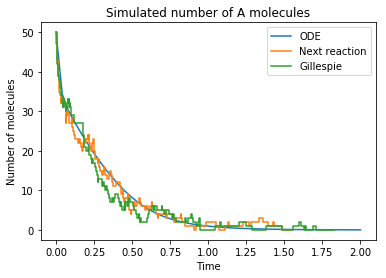

In [29]:
plt.plot(t_ode, sol[:,0])
plt.step(t_nr, y_nr[0], where='post')
plt.step(t_ssa, y_ssa[0], where='post')
plt.legend(['ODE', 'Next reaction', 'Gillespie'])
plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Simulated number of A molecules')
plt.show()

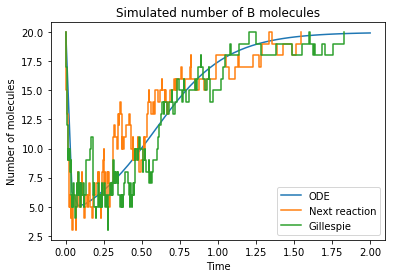

In [30]:
plt.plot(t_ode, sol[:,2])
plt.step(t_nr, y_nr[2], where='post')
plt.step(t_ssa, y_ssa[2], where='post')
plt.legend(['ODE', 'Next reaction', 'Gillespie'])
plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Simulated number of B molecules')
plt.show()

## Time-dependent reaction rates

If we now assume that the reaction rates can change explicitly as a function of time (that is $a_k = a_k(X(t), t)$), we can apply the next reaction method described above to this new case in a fairly straightforward way. $P_k$ and $T_k$ are defined in the same way as above, the only difference is that now $T_k$ is not necessarily a piecewise linear function of the absolute time $t$. 

In the algorithm described above, only steps 5 and 8 change. In step 5 to find the absolute firing times of each reaction $\Delta t_k$, we must now solve
$$\int_t^{t + \Delta t_k} a_k(X(t), s) ds = P_k - T_k.$$
In step 8 to advance each internal clock, we now have to set 
$$T_k = T_k + \int_t^{t + \Delta} a_k(X(t), s) ds.$$

The code below simulates the same chemical system as above, but with exponentially decreasing reaction rates. That is, $k^+(t) = k^+_0 \exp(-Rt)$ and similarly for the other reaction rates. As $R \rightarrow 0$, this system approaches the system above with constant reaction rates.

In [11]:
R = .9

In [12]:
def dyvar(y, t):
    a, c, b = y
    
    da = km*np.exp(-R*t)*c - kp*np.exp(-R*t)*a*b
    dc = kp*np.exp(-R*t)*a*b - (km + kcat)*np.exp(-R*t)*c
    db = (km + kcat)*np.exp(-R*t)*c - kp*np.exp(-R*t)*a*b
    
    return np.array([da, dc, db])

In [13]:
def nrvar(y0):
    a0, c0, b0 = y0
    
    a, b, c = np.array([a0]), np.array([b0]), np.array([c0])
    t = np.array([0])
    Tk = np.zeros(shape=3)
    
    rates = np.array([kp*a0*b0, km*c0, kcat*c0])
    del_t = np.zeros(shape=3)
    r = np.random.rand(3)
    P = np.log(1/r)

    while t[-1] < T:
        valid_indices = (P - Tk)*R < rates
        del_t[:] = np.inf
        del_t[valid_indices] = -1/R*np.log(1 - R*(P - Tk)[valid_indices]/(rates[valid_indices]))
        
        j = np.argmin(del_t)
        delta = del_t[j]
        
        if delta == np.inf:
            break
        
        t = np.append(t, t[-1] + delta)
        if j == 0:
            a = np.append(a, a[-1] - 1)
            b = np.append(b, b[-1] - 1)
            c = np.append(c, c[-1] + 1)
        elif j == 1:
            a = np.append(a, a[-1] + 1)
            b = np.append(b, b[-1] + 1)
            c = np.append(c, c[-1] - 1)
        elif j == 2:
            a = np.append(a, a[-1])
            b = np.append(b, b[-1] + 1)
            c = np.append(c, c[-1] - 1)
        
        Tk += rates/R*(np.exp(-R*t[-2]) - np.exp(-R*t[-1]))
        P[j] += np.log(1/np.random.rand())
        rates = np.array([kp*a[-1]*b[-1], km*c[-1], kcat*c[-1]])
    
    return np.array([a, c, b]), t

In [14]:
y_nrv, t_nrv = nrvar(y0)
sol = odeint(dyvar, y0, t_ode)

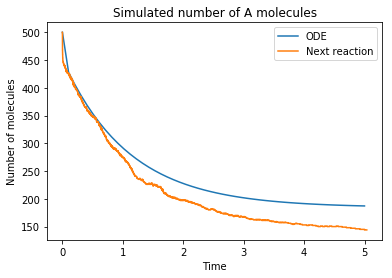

In [15]:
plt.plot(t_ode, sol[:,0])
plt.step(t_nrv, y_nrv[0], where='post')
plt.legend(['ODE', 'Next reaction'])
plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Simulated number of A molecules')
plt.show()

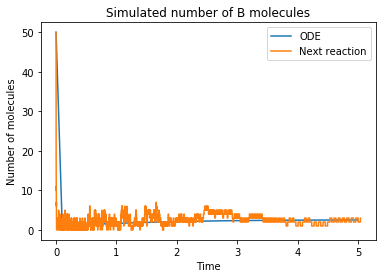

In [16]:
plt.plot(t_ode, sol[:,2])
plt.step(t_nrv, y_nrv[2], where='post')
plt.legend(['ODE', 'Next reaction'])
plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Simulated number of B molecules')
plt.show()